## Introduction
이번 실습에서는 좀 더 복잡한 데이터와 모델을 최적화해보도록 하겠습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from time import time

seed = 777
np.random.seed(seed)
tf.random.set_random_seed(seed) # for reproducibility

## Dataset info
cifar-10은 10가지 카테고리의 32x32 컬러(RGB) 이미지들로 구성되어 있으며 50,000장의 training data, 10,000장의 test data로 이루어져 있습니다.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.
y_train = y_train.astype(np.int64)
x_test = x_test.astype(np.float32) / 255.
y_test = y_test.astype(np.int64)

print(f"input shape: {x_train.shape}")
print(f"label shape: {y_train.shape}")

input shape: (50000, 32, 32, 3)
label shape: (50000, 1)


## Model 생성

In [3]:
def create_model(optimizer='adam', init='glorot_uniform'):
    model = keras.Sequential([
        # input layer
        keras.layers.Flatten(input_shape=(32, 32, 3)),
        keras.layers.Dropout(0.5),
        # hidden layers
        keras.layers.Dense(1024,kernel_initializer=init),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1024,kernel_initializer=init),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        # output layer
        keras.layers.Dense(10,kernel_initializer=init),
        keras.layers.Activation('softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model

In [4]:
model = create_model()
model.summary()
hist = model.fit(x_train, y_train, 
                 batch_size=1024, epochs=5,
                 validation_data=(x_test, y_test))

W0716 16:02:09.046936 139949282731840 deprecation.py:506] From /home/yongsu/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              3146752   
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

## Plot function

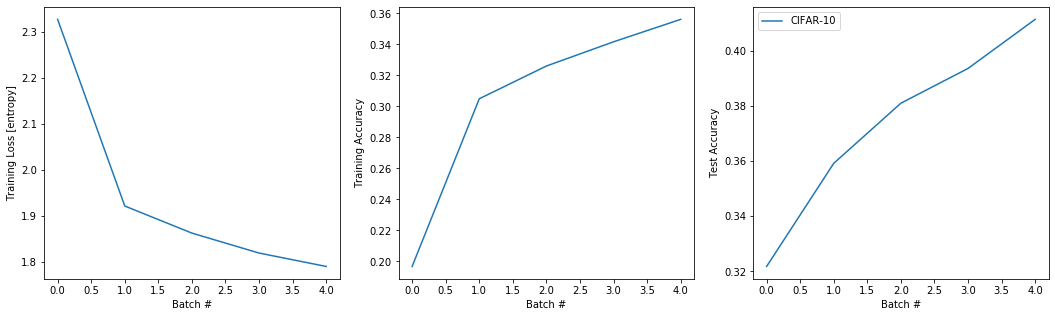

In [5]:
%matplotlib inline
def plot_fn(labels, train_loss_histories, train_acc_histories, test_acc_histories):
    fig = plt.figure(figsize=(18,5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)
    for label, train_loss_history, train_acc_history, test_acc_history in zip(labels, train_loss_histories, train_acc_histories, test_acc_histories):
        ax1.plot(train_loss_history, label=str(label))
        ax2.plot(train_acc_history, label=str(label))
        ax3.plot(test_acc_history, label=str(label))
        
    ax1.set_xlabel('Batch #')
    ax1.set_ylabel('Training Loss [entropy]')
    ax2.set_xlabel('Batch #')
    ax2.set_ylabel('Training Accuracy')
    ax3.set_xlabel('Batch #')
    ax3.set_ylabel('Test Accuracy')
    plt.legend()
    plt.show
plot_fn(['CIFAR-10'], [hist.history['loss']], [hist.history['acc']], [hist.history['val_acc']])

## Hyperparameter Optimization
scikit learn의 model_selection 모듈을 사용하면 간단하게 하이퍼파라미터 서치를 수행할 수 있습니다.

GridSearchCV는 K-fold cross validation을 기반으로 주어진 parameter grid를 모두 탐색하면서 최적의 하이퍼 파라미터를 찾아냅니다.

RandomizedSearchCV는 parameter grid를 모두 탐색하지 않고 랜덤하게 뽑은 몇 가지 하이퍼 파라미터 조합에 대해서만 탐색을 수행합니다.

자세한 내용은 [Sklearn Docs](https://scikit-learn.org/stable/modules/grid_search.html)에서 찾아볼 수 있습니다.

In [6]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
model = KerasClassifier(build_fn=create_model) # wrapper

# opt parameter candidates
optimizers = ['sgd', 'adam']
init = ['glorot_uniform', 'normal']
epochs = np.array([5, 10])
batches = np.array([128, 256, 1024])
# model parameters
params={}

# parameter grid generation
param_grid = dict(optimizer=optimizers, init=init, nb_epoch=epochs, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5) # 5-fold cross validation

In [7]:
# 각 hyperparameter에 따른 모델들을 학습합니다
start=time()
grid_result = grid.fit(x_train, y_train, **params)
end=time()

10000/10000 [==============================] - 0s 28us/sample - loss: 1.8638 - acc: 0.3199


W0716 16:03:12.781950 139949282731840 deprecation.py:506] From /home/yongsu/anaconda3/envs/tf114/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000/10000 [==============================] - 0s 35us/sample - loss: 2.1230 - acc: 0.2310


10000/10000 [==============================] - 0s 49us/sample - loss: 2.0504 - acc: 0.2532


50000/50000 [==============================] - 3s 52us/sample - loss: 1.9894 - acc: 0.2842


In [8]:
# 탐색된 모델들의 성능을 비교합니다
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("total time:",end-start)

Best: 0.352500 using {'batch_size': 128, 'init': 'glorot_uniform', 'nb_epoch': 5, 'optimizer': 'adam'}
0.266820 (0.012260) with: {'batch_size': 128, 'init': 'glorot_uniform', 'nb_epoch': 5, 'optimizer': 'sgd'}
0.352500 (0.008250) with: {'batch_size': 128, 'init': 'glorot_uniform', 'nb_epoch': 5, 'optimizer': 'adam'}
0.271260 (0.014467) with: {'batch_size': 128, 'init': 'glorot_uniform', 'nb_epoch': 10, 'optimizer': 'sgd'}
0.343320 (0.014494) with: {'batch_size': 128, 'init': 'glorot_uniform', 'nb_epoch': 10, 'optimizer': 'adam'}
0.233400 (0.013210) with: {'batch_size': 128, 'init': 'normal', 'nb_epoch': 5, 'optimizer': 'sgd'}
0.322980 (0.006992) with: {'batch_size': 128, 'init': 'normal', 'nb_epoch': 5, 'optimizer': 'adam'}
0.221840 (0.012334) with: {'batch_size': 128, 'init': 'normal', 'nb_epoch': 10, 'optimizer': 'sgd'}
0.325160 (0.006446) with: {'batch_size': 128, 'init': 'normal', 'nb_epoch': 10, 'optimizer': 'adam'}
0.241800 (0.017266) with: {'batch_size': 256, 'init': 'glorot_uni

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 5s 93us/sample - loss: 2.0312 - acc: 0.2696 - val_loss: 1.8179 - val_acc: 0.3502
Epoch 2/5
50000/50000 [==============================] - 2s 45us/sample - loss: 1.8481 - acc: 0.3306 - val_loss: 1.7229 - val_acc: 0.3880
Epoch 3/5
50000/50000 [==============================] - 2s 46us/sample - loss: 1.7983 - acc: 0.3506 - val_loss: 1.6941 - val_acc: 0.4108
Epoch 4/5
50000/50000 [==============================] - 2s 45us/sample - loss: 1.7651 - acc: 0.3615 - val_loss: 1.6528 - val_acc: 0.4136
Epoch 5/5
50000/50000 [==============================] - 2s 45us/sample - loss: 1.7352 - acc: 0.3760 - val_loss: 1.6302 - val_acc: 0.4243


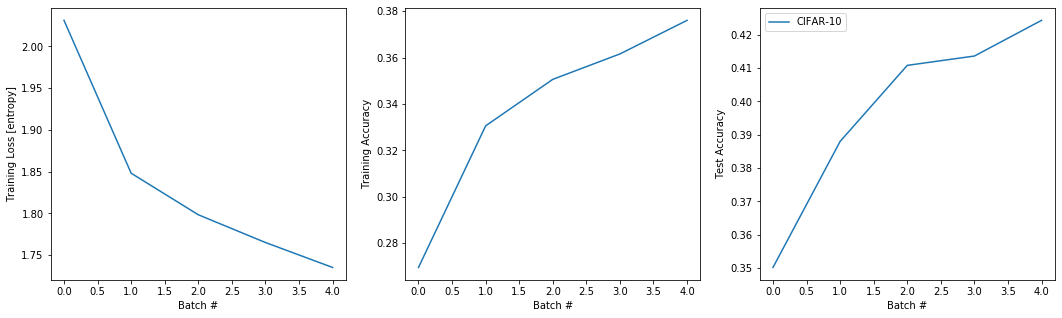

In [9]:
# 가장 좋은 validation accuracy를 보인 하이퍼파라미터로 모든 training data를 포함하여 다시 학습합니다
best_model = create_model(init=grid_result.best_params_['init'], optimizer=grid_result.best_params_['optimizer'])
best_hist = best_model.fit(x_train, y_train,
                           batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['nb_epoch'],
                           validation_data=(x_test, y_test))
plot_fn(['CIFAR-10'], [best_hist.history['loss']], [best_hist.history['acc']], [best_hist.history['val_acc']])